In [1]:
import datetime as dt
from pytz import timezone
from matplotlib import pyplot as plt
import pandas as pd
from IPython.display import HTML
from money_squirrel.bin import utils

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 7)

COINS = utils.load_config("coins")

def display_all(df):
    return HTML(df.to_html())

2017-07-08 06:08:52,581|money_squirrel.bin.utils|INFO|Instantiated logger w/ name=money_squirrel.bin.utils
2017-07-08 06:08:52,583|money_squirrel.bin.utils|INFO|Loading JSON from /Users/ravdek/code/money_squirrel/money_squirrel/config/coins.json


In [2]:
gdax_price = utils.query_pg("select * from gdax_api_quote")

2017-07-08 06:08:53,340|money_squirrel.bin.utils|INFO|Loading JSON from /Users/ravdek/code/money_squirrel/money_squirrel/config/postgres.json
2017-07-08 06:08:53,341|money_squirrel.bin.utils|INFO|Connecting to postgres DB @ localhost
2017-07-08 06:08:53,346|money_squirrel.bin.utils|INFO|Executing query:

select * from gdax_api_quote



In [3]:
gdax_price.head()

,id,product_id,granularity,dt,low,high,open,close,volume
0,1,BTC-USD,20,2017-06-25 23:39:20-07:00,2489.36,2489.71,2489.47,2489.36,4.232061
1,2,BTC-USD,20,2017-06-25 23:38:40-07:00,2488.17,2489.96,2488.17,2489.96,0.102200
2,3,BTC-USD,20,2017-06-25 23:38:20-07:00,2486.56,2489.96,2487.47,2489.96,2.362538
3,4,BTC-USD,20,2017-06-25 23:38:00-07:00,2486.24,2489.97,2486.24,2489.97,4.472527
4,5,BTC-USD,20,2017-06-25 23:37:40-07:00,2486.11,2487.67,2486.11,2486.16,2.713689


In [4]:
gdax_price['granularity'].value_counts()

60    759081
20        43
Name: granularity, dtype: int64

In [5]:
gdax_price.loc[0, 'dt'].__class__

datetime.datetime

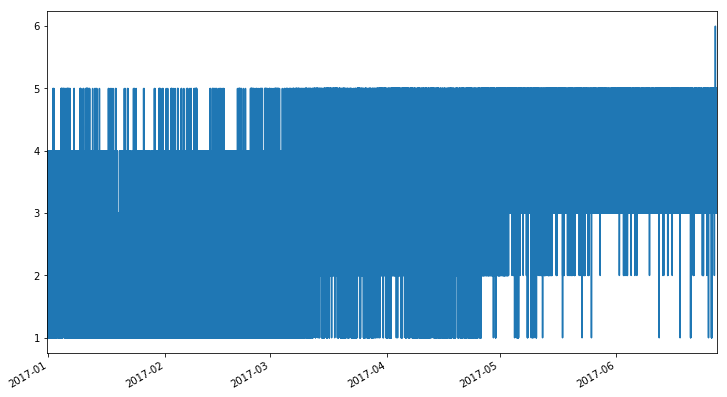

In [6]:
gdax_price.loc[gdax_price['granularity']==60, 'dt'].value_counts().plot()

# quality

What % of the time do we have each product?

Can we fill in blanks by combining product info?

In [16]:
close_pivot = gdax_price[
    (gdax_price['granularity']==60)
    & (gdax_price['dt'] <= utils.get_utc_dt(2017,6,15))
].pivot(
    index='dt',
    columns='product_id',
    values='close'
)

In [17]:
close_pivot.applymap(pd.notnull).applymap(int).mean()

product_id
BTC-USD    0.981031
ETH-BTC    0.364634
ETH-USD    0.855354
LTC-BTC    0.268053
LTC-USD    0.460031
dtype: float64

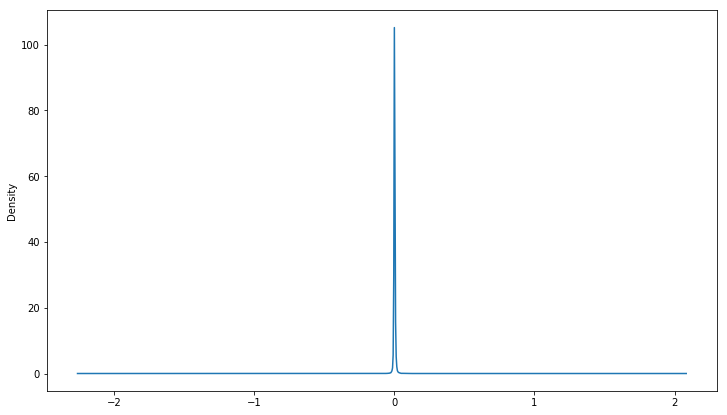

In [24]:
# checking if prices aggree
close_pivot[
    (close_pivot['BTC-USD'].notnull())
    & (close_pivot['LTC-BTC'].notnull())
    & (close_pivot['LTC-USD'].notnull())
].assign(
    commuting_ltc_usd=lambda df: df['LTC-BTC']*df['BTC-USD']
).assign(
    pct_diff=lambda df: (df['LTC-USD'] - df['commuting_ltc_usd'])/df['LTC-USD']
)['pct_diff'].plot(kind='kde')

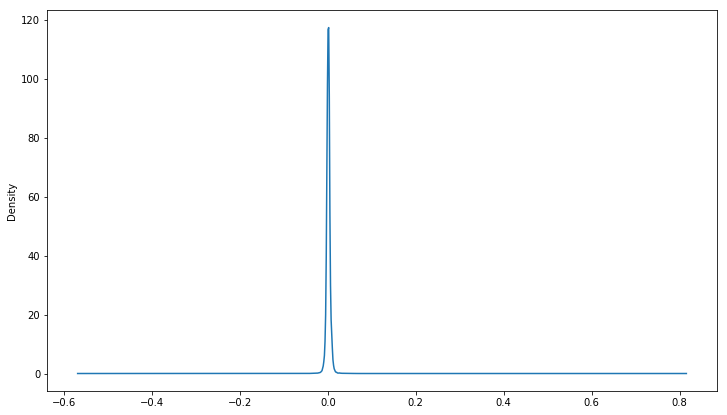

In [23]:
# checking if prices aggree
close_pivot[
    (close_pivot['BTC-USD'].notnull())
    & (close_pivot['ETH-BTC'].notnull())
    & (close_pivot['ETH-USD'].notnull())
].assign(
    commuting_eth_usd=lambda df: df['ETH-BTC']*df['BTC-USD']
).assign(
    pct_diff=lambda df: (df['ETH-USD'] - df['commuting_eth_usd'])/df['ETH-USD']
)['pct_diff'].plot(kind='kde')

In [33]:
# What things are missing together most frequently?
for c in close_pivot.columns:
    print c
    print close_pivot[close_pivot[c].isnull()].isnull().mean()
    print

BTC-USD
product_id
BTC-USD    1.000000
ETH-BTC    0.735468
ETH-USD    0.274977
LTC-BTC    0.902816
LTC-USD    0.824251
dtype: float64

ETH-BTC
product_id
BTC-USD    0.021958
ETH-BTC    1.000000
ETH-USD    0.194948
LTC-BTC    0.795500
LTC-USD    0.628570
dtype: float64

ETH-USD
product_id
BTC-USD    0.036061
ETH-BTC    0.856322
ETH-USD    1.000000
LTC-BTC    0.925972
LTC-USD    0.860401
dtype: float64

LTC-BTC
product_id
BTC-USD    0.023397
ETH-BTC    0.690533
ETH-USD    0.182989
LTC-BTC    1.000000
LTC-USD    0.677398
dtype: float64

LTC-USD
product_id
BTC-USD    0.028956
ETH-BTC    0.739620
ETH-USD    0.230483
LTC-BTC    0.918237
LTC-USD    1.000000
dtype: float64



In [36]:
close_pivot.loc[close_pivot.index >= utils.get_utc_dt(2017,4,1),:].count()

product_id
BTC-USD    107442
ETH-BTC     50923
ETH-USD    104952
LTC-BTC     52579
LTC-USD     88609
dtype: int64